#Assignment:

You have been provided two files, scenario1.txt and scenario2.txt
which each contain simulated application logs in the following format:

Column 1: # seconds since time t=0

Column 2: # requests processed since last log

Column 3: Mean response time for requests processed since last log

The logging frequency is 1 per second, but there are no logs for seconds in
which there were no requests. The data span two simulated weeks and were
generated under an idealized/simplified model in which there is a single
application server which processes requests sequentially using a single thread.
If a request arrives while the server is busy, it waits in a queue until
the server is free to process it. There is no limit to the size of the queue.

For each scenario, please answer the following questions.
Note that we define "week 2" to begin at second 626400 (6 am on the 8th day).

1) How much has the mean response time (specifically, the mean of the response
times for each individual request) changed from week 1 to week 2?

2) Create a plot illustrating the probability distribution of the amount of
server time it takes to process a request (excluding the time the request
spends waiting in the queue).

3) Propose a potential cause for the change in response times. Give both a
qualitative answer as if you were explaining it to a client and a quantitative
answer as if you were explaining it to a statistician. Create 1 or 2 plots to
support and illustrate your argument.

In [2]:
import pandas as pd
import numpy as np
from scipy import signal
from numpy.random import rand
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(context='poster', style='dark')

##Scenario 2

In [3]:
df = pd.read_csv('scenario2.txt', header=None, sep='\t')
df.columns=['time', 'num_requests', 'mean_resp_time']

print('top ten entries:')
df.head(10)

top ten entries:


,time,num_requests,mean_resp_time
0,21601,5,0.069
1,21602,3,0.076
2,21606,3,0.071
3,21608,2,0.097
4,21609,1,0.045
5,21610,1,0.069
6,21611,1,0.066
7,21613,3,0.122
8,21614,1,0.088
9,21615,3,0.101


###Answer Question I:

In [4]:
early_df = df.iloc[:626400]
late_df = df.iloc[626400:]

print("Mean response time for Week I:", early_df.mean_resp_time.mean())
print("Mean response time for Week II:", late_df.mean_resp_time.mean())
print("Difference in %s sec" % float('%.2g' % (late_df.mean_resp_time.mean() - early_df.mean_resp_time.mean())))

Mean response time for Week I: 0.162686738506
Mean response time for Week II: 0.224895307149
Difference in 0.062 sec


In [4]:
def split_days(data, interval=85000):
    ix = np.arange(0, len(data), interval)

    days = []

    for i in range(len(ix)-1):
        days.append(data[ix[i]:ix[i+1]])
    
    days = np.array(days)
    
    #last day, though it might be incomplete
    d = data[ix[-1]:]
    e = np.empty(days.shape[1] - d.shape[0])
    e[:] = np.NAN
    d_n = np.reshape(np.concatenate([d,e]), [1, interval])
    
    days = np.concatenate([days, d_n], axis=0)
    
    return days

def plot_days(days, plot_raw=True, plot_mean=True, plot_median=True):
    
    if plot_raw:
        for i in range(len(days)):
            plt.plot(days[i], label=i);

        plt.legend(loc='best')
        plt.title('raw data')

    if plot_mean:
#         if ~compare:
        plt.figure()
        plt.plot(np.nanmean(days, axis=0))
        plt.title('mean')
    
    if plot_median:
        plt.figure()
        
        plt.plot(np.nanmedian(days, axis=0), label='median')
        plt.title('median')
        
#smooth

import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

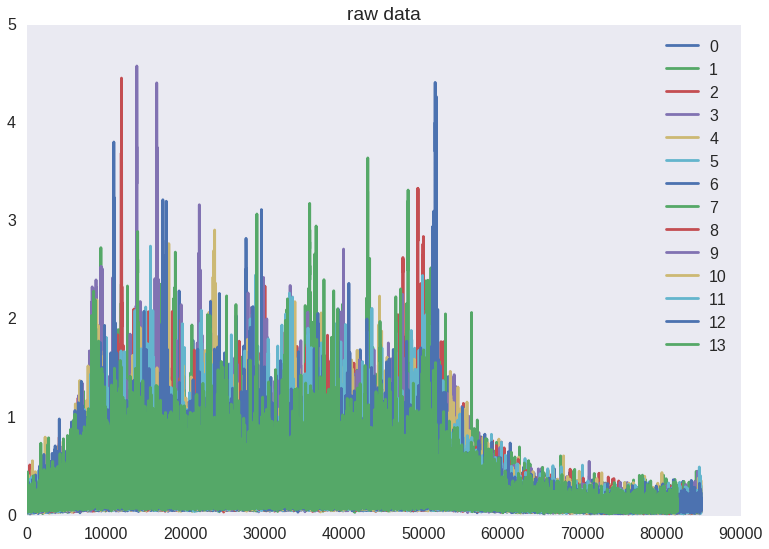

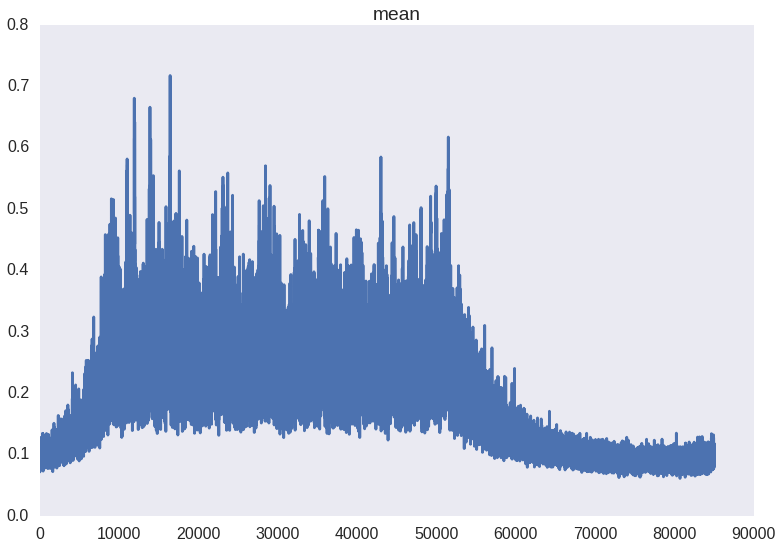

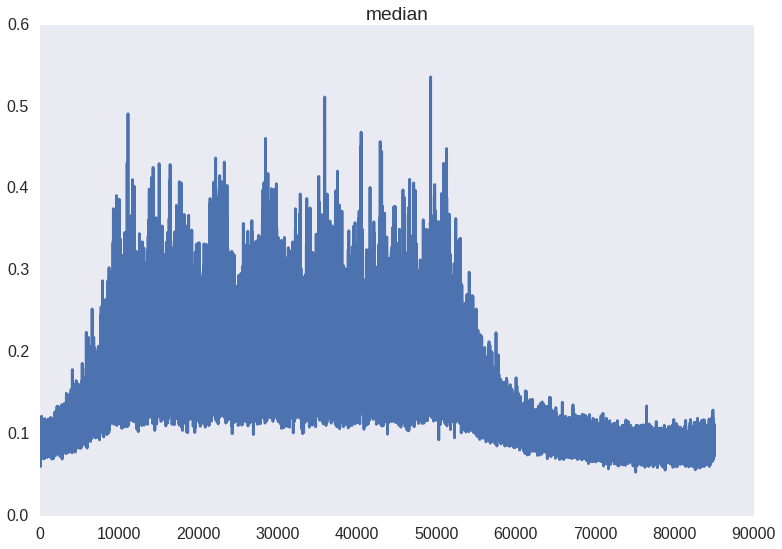

In [6]:
plt.figure()
plot_days(split_days(df.mean_resp_time))
# plt.title('mean response times')

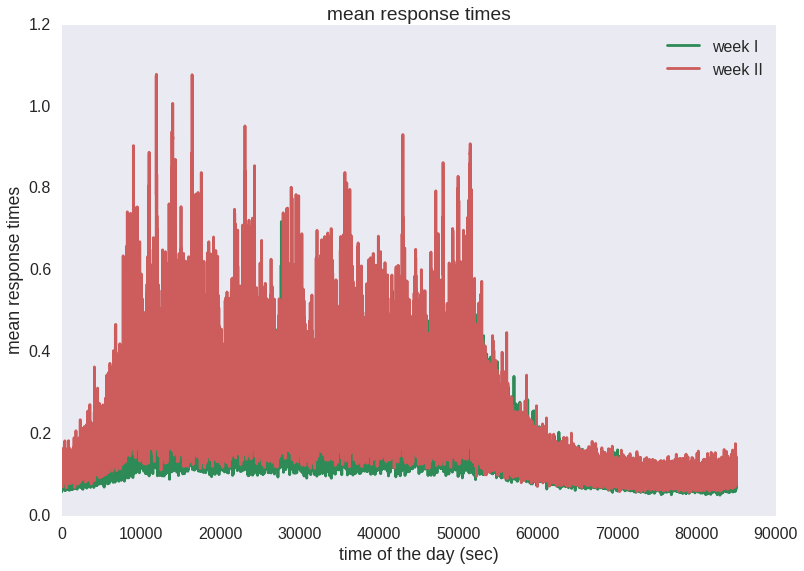

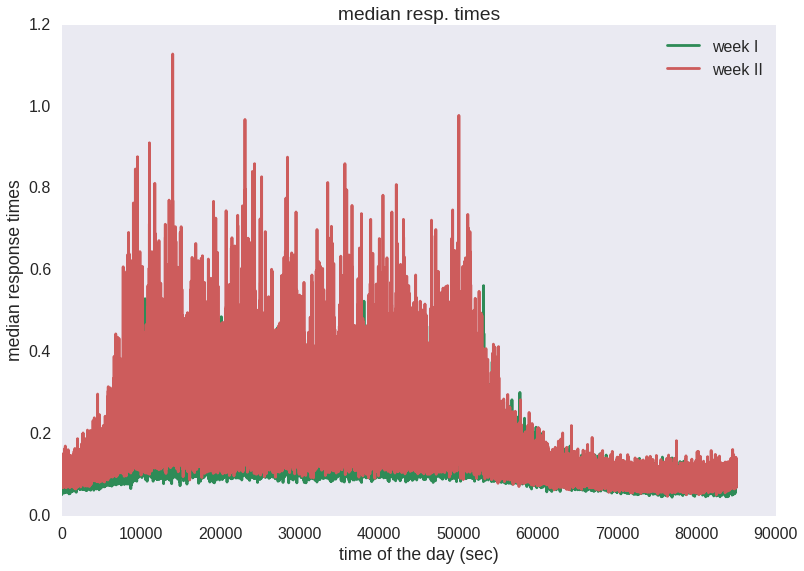

In [7]:
plt.plot(np.nanmean(split_days(df.mean_resp_time.values)[:7], axis=0), color='seagreen', label='week I')
plt.plot(np.nanmean(split_days(df.mean_resp_time.values)[7:], axis=0), color='indianred', label='week II')
plt.legend(loc='best')
plt.title('mean response times')
plt.xlabel('time of the day (sec)')
plt.ylabel('mean response times')

plt.figure()
plt.plot(np.nanmedian(split_days(df.mean_resp_time.values)[:7], axis=0), color='seagreen', label='week I')
plt.plot(np.nanmedian(split_days(df.mean_resp_time.values)[7:], axis=0), color='indianred', label='week II')
plt.legend(loc='best')
plt.title('median resp. times')
plt.xlabel('time of the day (sec)')
plt.ylabel('median response times')

(0, 9.75)

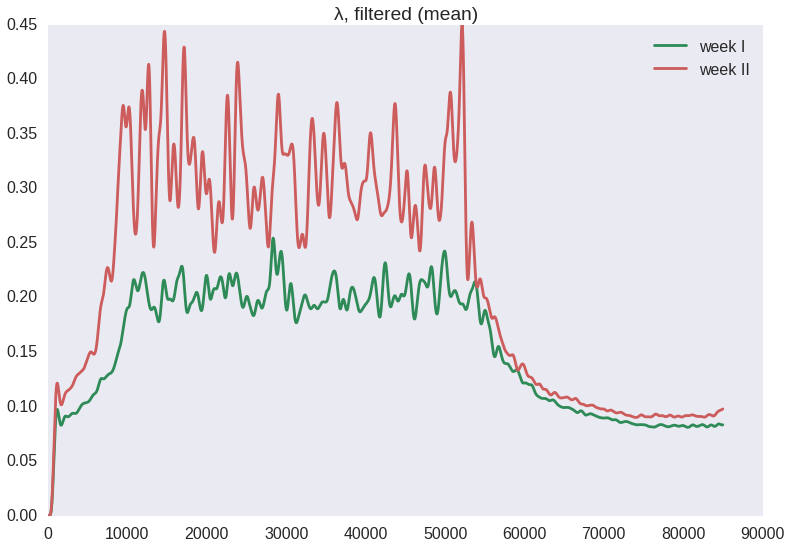

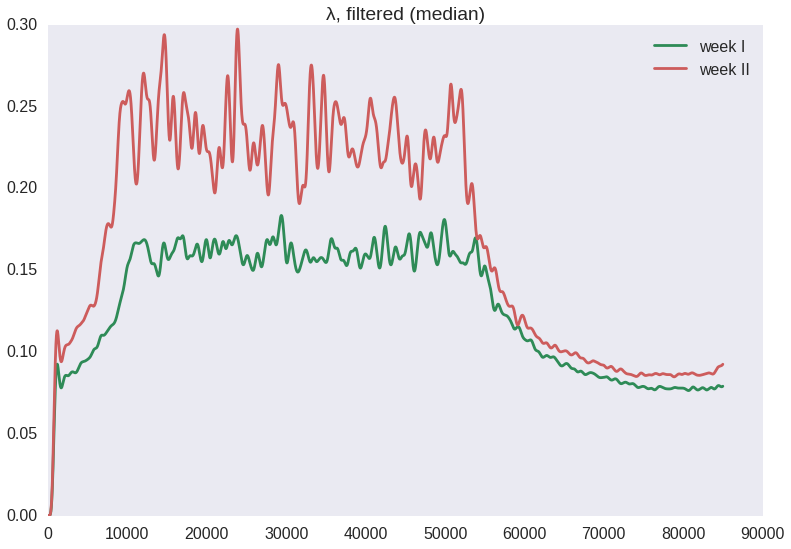

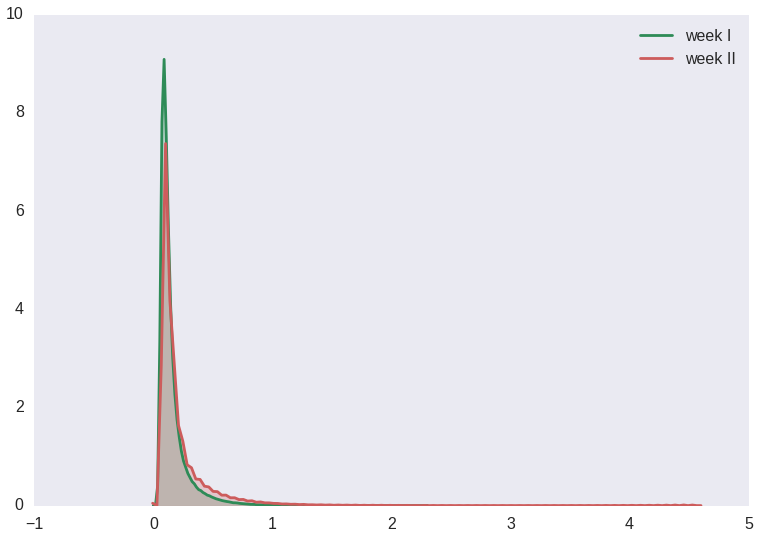

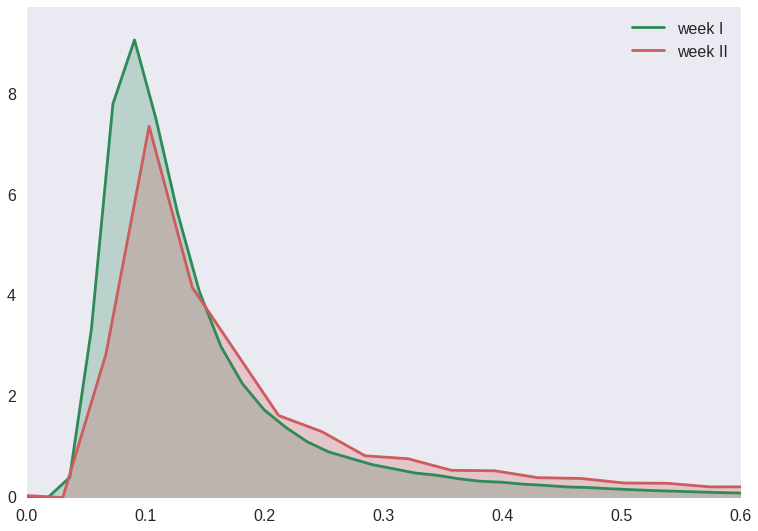

In [8]:
c_off = 1/1000

plt.plot(butter_lowpass_filter(np.nanmean(split_days(df.mean_resp_time)[:7], axis=0), cutoff=c_off, fs=1, order=6),
        color='seagreen', label='week I')
plt.plot(butter_lowpass_filter(np.nanmean(split_days(df.mean_resp_time)[7:], axis=0), cutoff=c_off, fs=1, order=6),
        color='indianred', label='week II')
plt.legend(loc='best')
plt.title('λ, filtered (mean)')

plt.figure()

plt.plot(butter_lowpass_filter(np.nanmedian(split_days(df.mean_resp_time)[:7], axis=0), cutoff=c_off, fs=1, order=6),
        color='seagreen', label='week I')
plt.plot(butter_lowpass_filter(np.nanmedian(split_days(df.mean_resp_time)[7:], axis=0), cutoff=c_off, fs=1, order=6),
        color='indianred', label='week II')
plt.legend(loc='best')
plt.title('λ, filtered (median)')

plt.figure()

sns.kdeplot(df.iloc[:85000*6].mean_resp_time, label='week I', color='seagreen', shade=True)
sns.kdeplot(df.iloc[85000*6:].mean_resp_time, label='week II', color='indianred', shade=True);

plt.figure()

sns.kdeplot(df.iloc[:85000*6].mean_resp_time, label='week I', color='seagreen', shade=True)
sns.kdeplot(df.iloc[85000*6:].mean_resp_time, label='week II', color='indianred', shade=True);
plt.xlim(0, 0.6)
plt.ylim(0, 9.75)

So far we see:

* Response times for week II are heavily pushed toward higher values
* There are three general phases of response times: a) early in the cycle: low, rises to b) plateau of high values for most of the day, c) drops to low values again

The fact that the distribution of response times is pushed to the right for week II could be explained by heavier traffic, longer service times (from tasks demanding longer service), or both.

### Answer questions 2 and 3:

I'll calculate the following stats from rolling averages:

<b>Tr</b>: mean response time

<b>Q</b>: mean number of requests in the system

<b>λ</b>: mean request arrival rate <b>= Q / Tr</b>

Finally, <b>Ts</b> (service time) <b>= Tr / (1+Q)</b>

I'll then create arrays of each value for the total number of bins for weeks 1 and 2 ('early' and 'late', resp.).

Reference for Queuing Theory: http://williams.comp.ncat.edu/comp755/Q.pdf

In [5]:
#smooth

import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [6]:
data = df.num_requests

# for i in list(range(1390, 1420, 10)):
# #     print(i)
#     y = butter_lowpass_filter(data, cutoff=1/i, fs=1, order=6)  
#     plt.figure()
#     plt.plot(y, label='cutoff: {}'.format(i))
#     plt.legend(loc='best')

In [7]:
df['num_reqs_filtered'] = butter_lowpass_filter(data, cutoff=1/1400, fs=1, order=6)
df['rolling_resp_time_mean'] = pd.rolling_mean(df.mean_resp_time, window=60, min_periods=1)
df['rolling_resp_time_median'] = pd.rolling_median(df.mean_resp_time, window=60, min_periods=1)
df['rolling_reqs'] = pd.rolling_mean(df.num_reqs_filtered, window=60, min_periods=1)

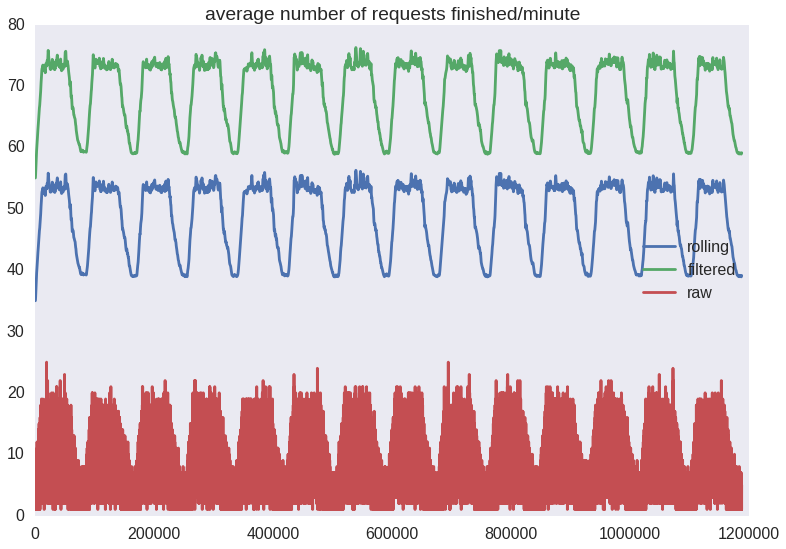

In [8]:
plt.plot(df.rolling_reqs+35, label='rolling')
plt.plot(df.num_reqs_filtered+55, label='filtered')
plt.plot(df.num_requests, label='raw')
plt.legend(loc='right') #no really good location :(

plt.title('average number of requests finished/minute')

(0, 160000)

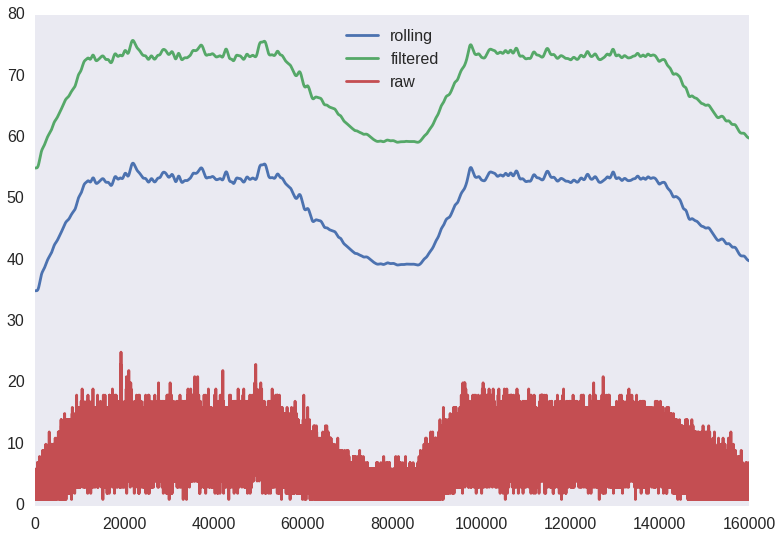

In [9]:
plt.plot(df.rolling_reqs.values+35, label='rolling')
plt.plot(df.num_reqs_filtered.values+55, label='filtered')
plt.plot(df.num_requests.values, label='raw')
plt.legend(loc='best')
plt.xlim(0, 160000)

In [14]:

# data = df.rolling_reqs.values

# ix = np.arange(0, len(df.rolling_reqs), 85000)
# d = data[ix[-1]:]

days = split_days(df.rolling_reqs.values)
# days.shape

# e = np.empty(days.shape[1] - d.shape[0])
# e[:] = np.NAN

# e_n = np.reshape(np.concatenate([d,e]), [1, 85000])

# print(e_n.shape)
# print(days.shape)

# np.concatenate([days, e_n], axis=0).shape

# plt.plot(np.nanmean(days, axis=0))

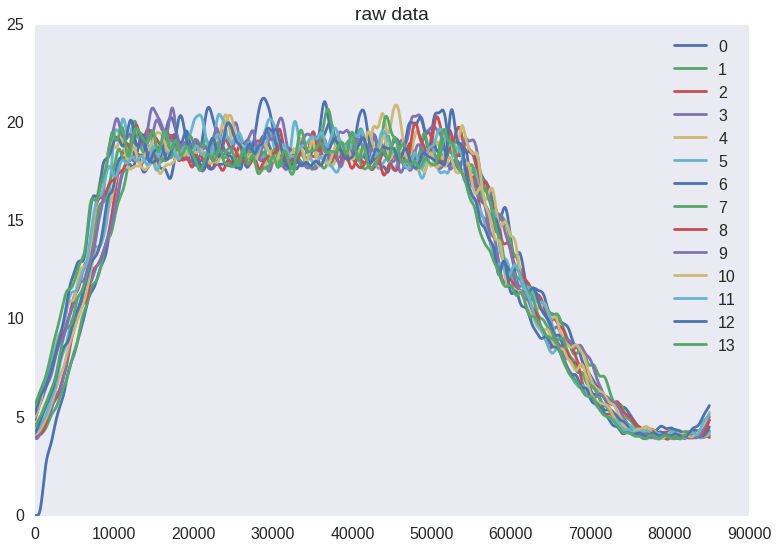

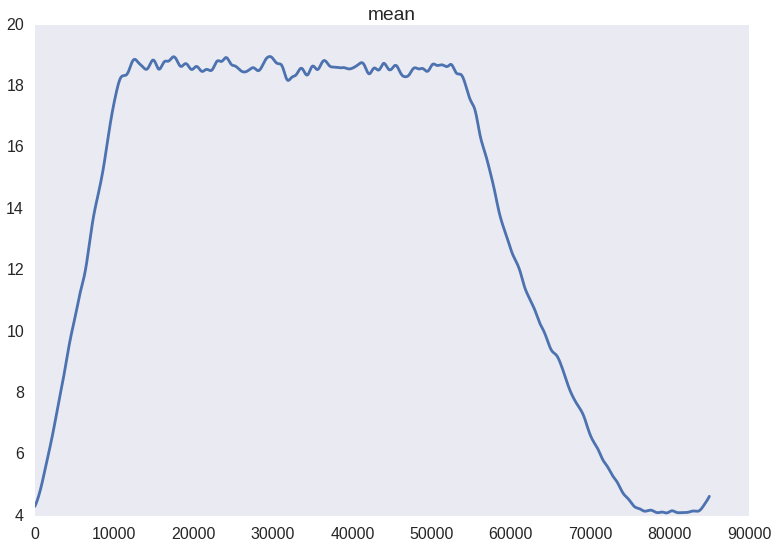

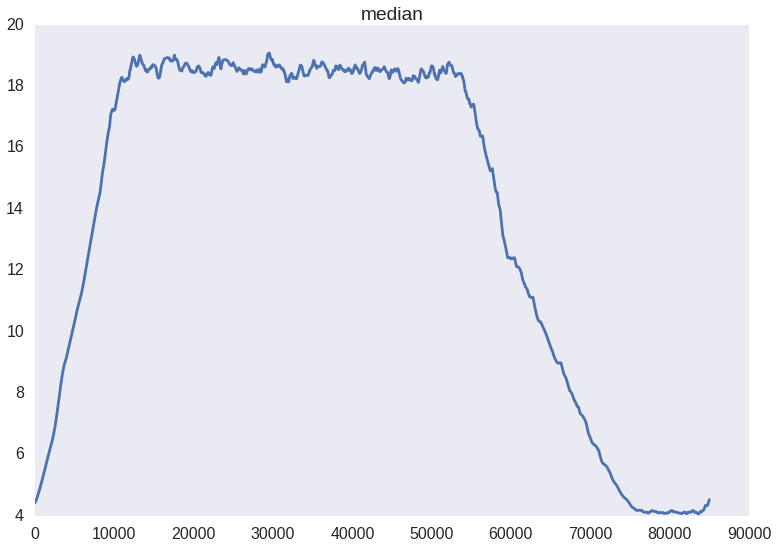

In [15]:
days = split_days(df.rolling_reqs.values)
plot_days(days)

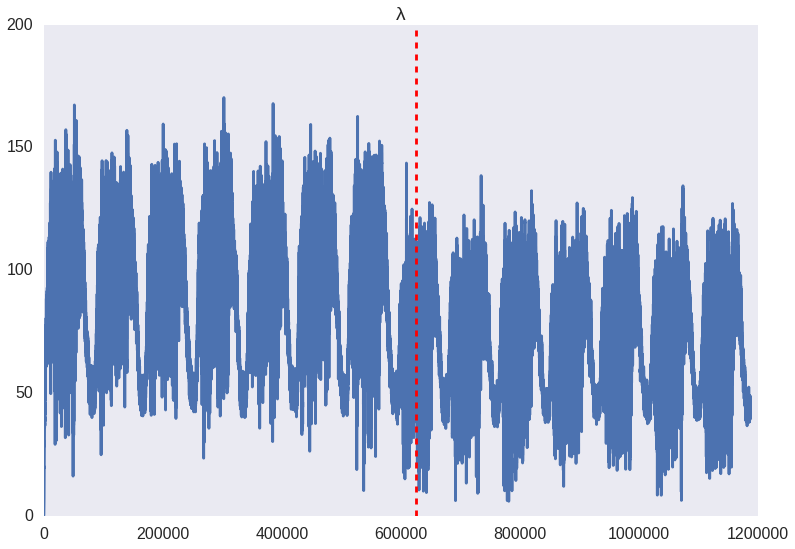

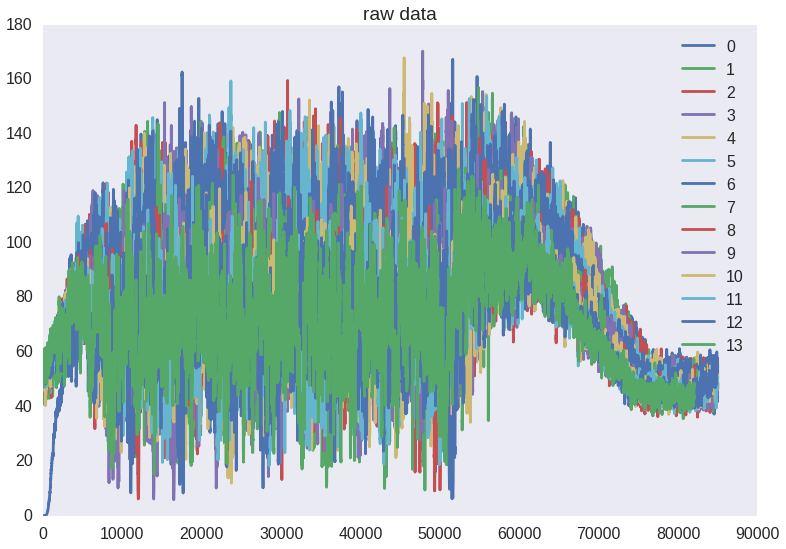

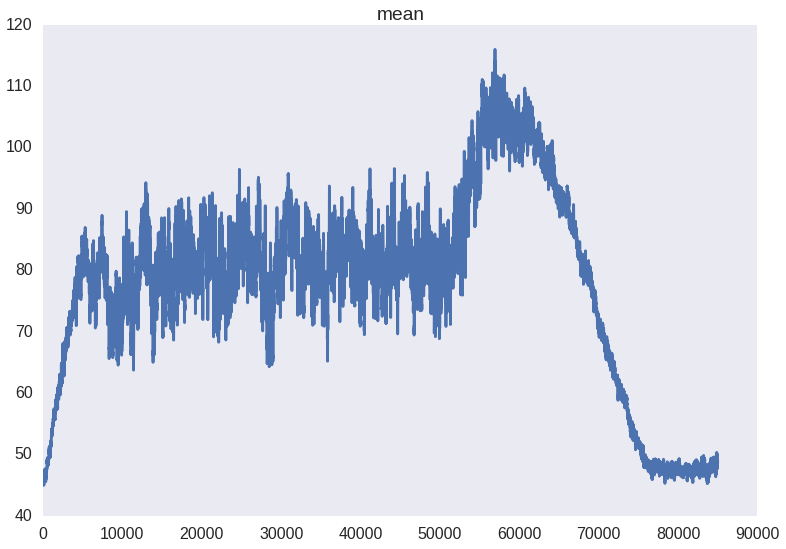

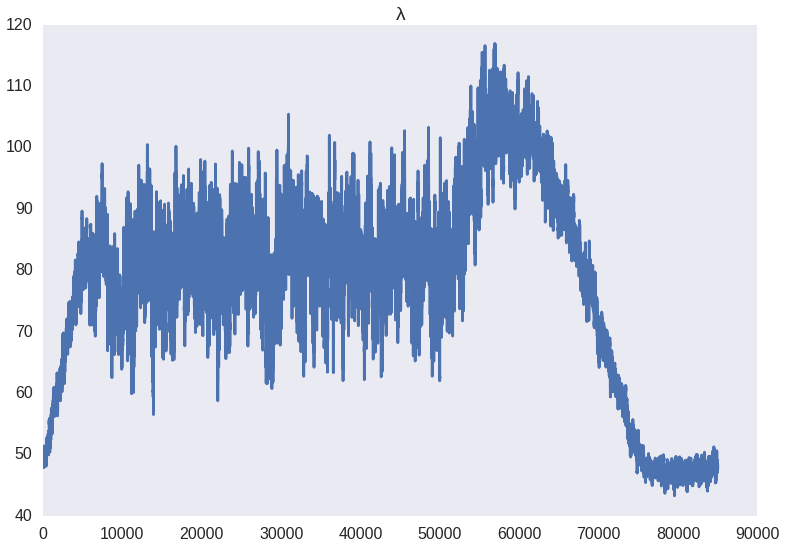

In [10]:
df['λ'] = df.rolling_reqs / df.rolling_resp_time_mean
plt.plot(df.λ)
plt.plot([626400,626400], [0, 200], 'r--')
plt.title('λ')

plt.figure()
plot_days(split_days(df.λ))
plt.title('λ')

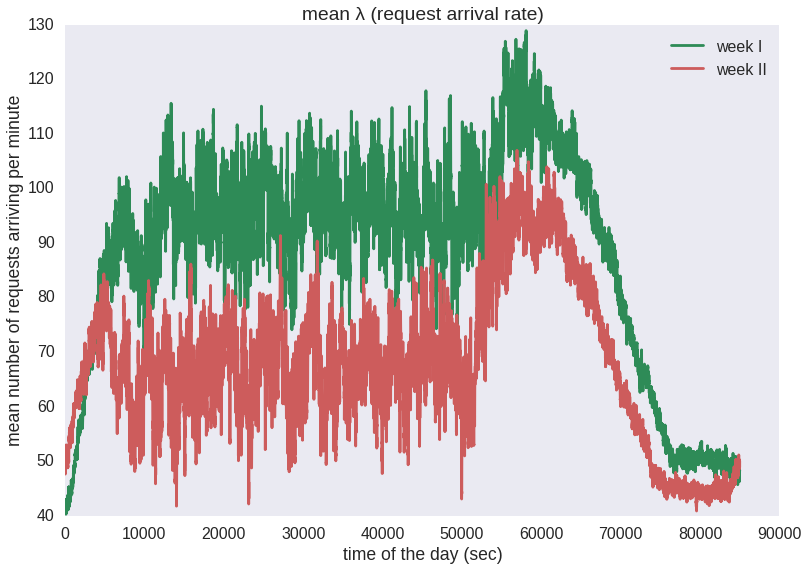

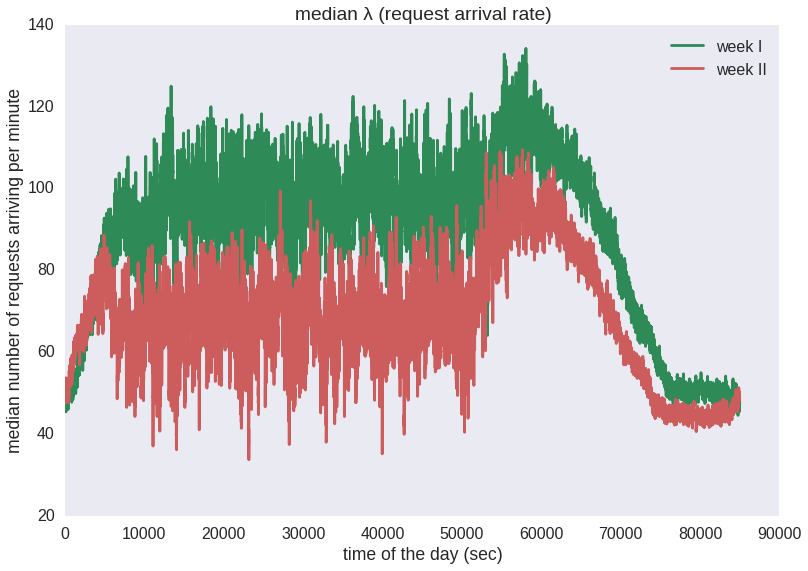

In [17]:
plt.plot(np.nanmean(split_days(df.λ)[:7], axis=0), color='seagreen', label='week I')
plt.plot(np.nanmean(split_days(df.λ)[7:], axis=0), color='indianred', label='week II')
plt.legend(loc='best')
plt.title('mean λ (request arrival rate)')
plt.xlabel('time of the day (sec)')
plt.ylabel('mean number of requests arriving per minute')

plt.figure()
plt.plot(np.nanmedian(split_days(df.λ)[:7], axis=0), color='seagreen', label='week I')
plt.plot(np.nanmedian(split_days(df.λ)[7:], axis=0), color='indianred', label='week II')
plt.legend(loc='best')
plt.title('median λ (request arrival rate)')
plt.xlabel('time of the day (sec)')
plt.ylabel('median number of requests arriving per minute')

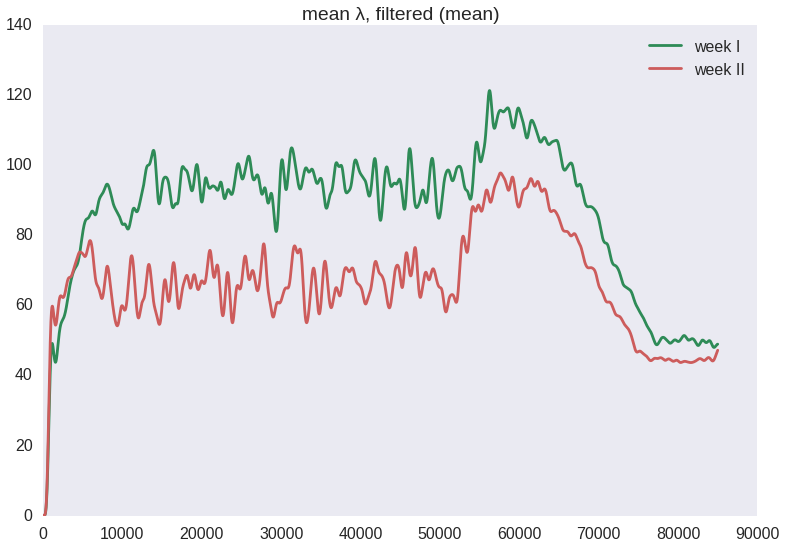

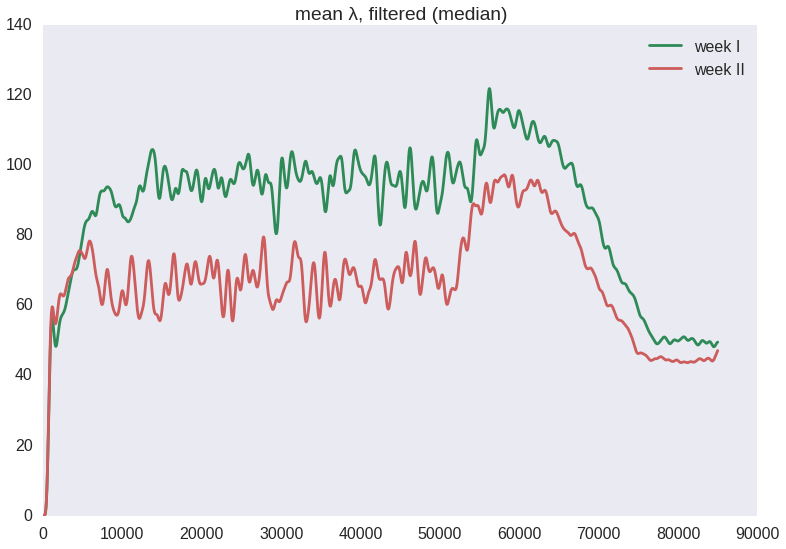

In [18]:
c_off = 1/1000

plt.plot(butter_lowpass_filter(np.nanmean(split_days(df.λ)[:7], axis=0), cutoff=c_off, fs=1, order=6),
        color='seagreen', label='week I')
plt.plot(butter_lowpass_filter(np.nanmean(split_days(df.λ)[7:], axis=0), cutoff=c_off, fs=1, order=6),
        color='indianred', label='week II')
plt.legend(loc='best')
plt.title('mean λ, filtered (mean)')

plt.figure()

c_off = 1/1000

plt.plot(butter_lowpass_filter(np.nanmedian(split_days(df.λ)[:7], axis=0), cutoff=c_off, fs=1, order=6),
        color='seagreen', label='week I')
plt.plot(butter_lowpass_filter(np.nanmedian(split_days(df.λ)[7:], axis=0), cutoff=c_off, fs=1, order=6),
        color='indianred', label='week II')
plt.legend(loc='best')
plt.title('mean λ, filtered (median)')

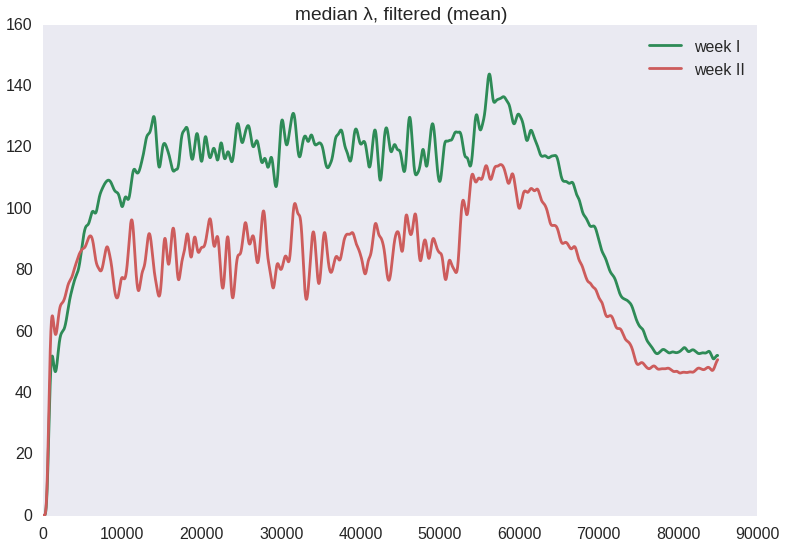

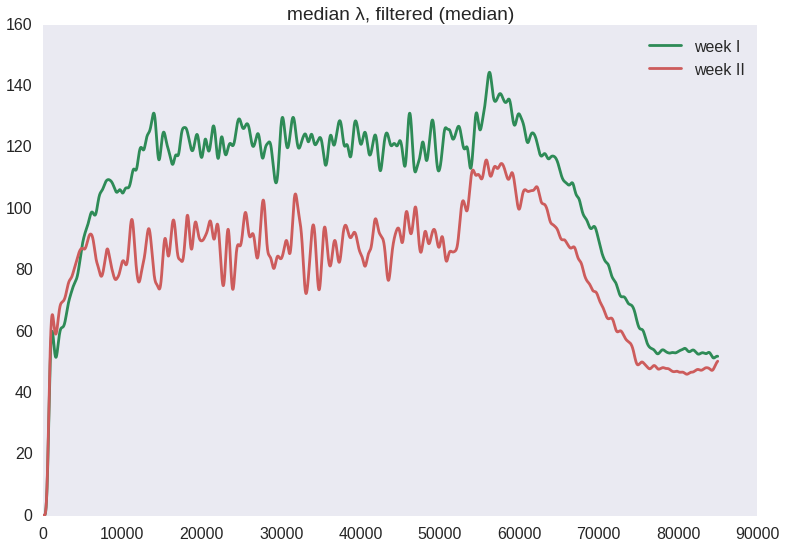

In [19]:
df['λ_median'] = df.rolling_reqs / df.rolling_resp_time_median

plt.plot(butter_lowpass_filter(np.nanmean(split_days(df.λ_median)[:7], axis=0), cutoff=c_off, fs=1, order=6),
        color='seagreen', label='week I')
plt.plot(butter_lowpass_filter(np.nanmean(split_days(df.λ_median)[7:], axis=0), cutoff=c_off, fs=1, order=6),
        color='indianred', label='week II')
plt.legend(loc='best')
plt.title('median λ, filtered (mean)')

plt.figure()

c_off = 1/1000

plt.plot(butter_lowpass_filter(np.nanmedian(split_days(df.λ_median)[:7], axis=0), cutoff=c_off, fs=1, order=6),
        color='seagreen', label='week I')
plt.plot(butter_lowpass_filter(np.nanmedian(split_days(df.λ_median)[7:], axis=0), cutoff=c_off, fs=1, order=6),
        color='indianred', label='week II')
plt.legend(loc='best')
plt.title('median λ, filtered (median)')

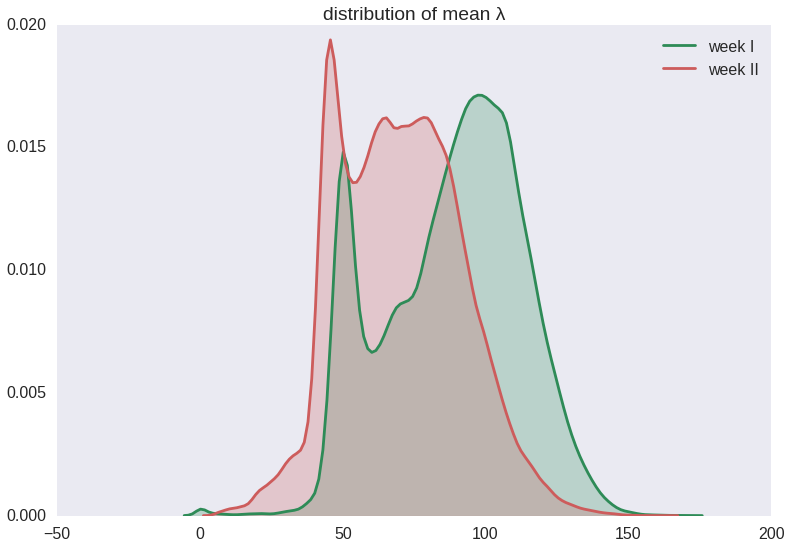

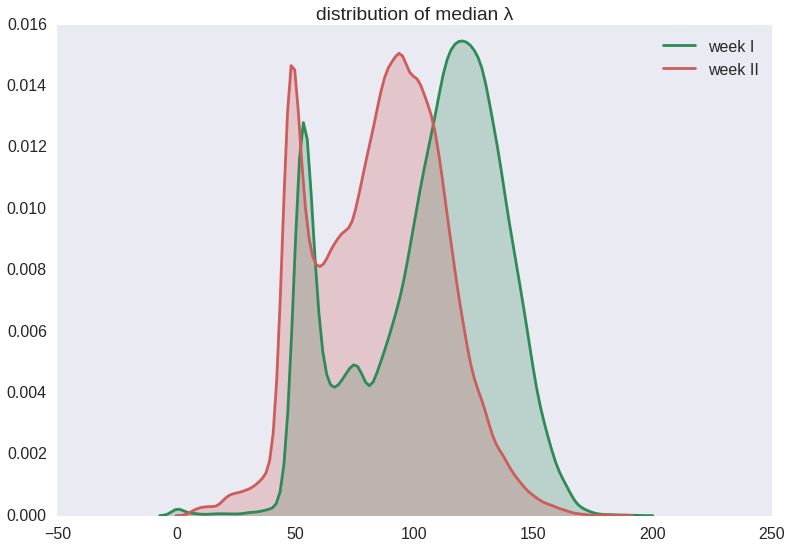

In [20]:
sns.kdeplot(df.iloc[:85000*6].λ, label='week I', color='seagreen', shade=True)
sns.kdeplot(df.iloc[85000*6:].λ, label='week II', color='indianred', shade=True)
plt.title('distribution of mean λ')

plt.figure()

sns.kdeplot(df.iloc[:85000*6].λ_median, label='week I', color='seagreen', shade=True)
sns.kdeplot(df.iloc[85000*6:].λ_median, label='week II', color='indianred', shade=True)
plt.title('distribution of median λ')

###Unlike in Scenario I, where there was a slight difference in arrival rate, in this scenario, the difference is stronger, but the values are actually lower for week II!

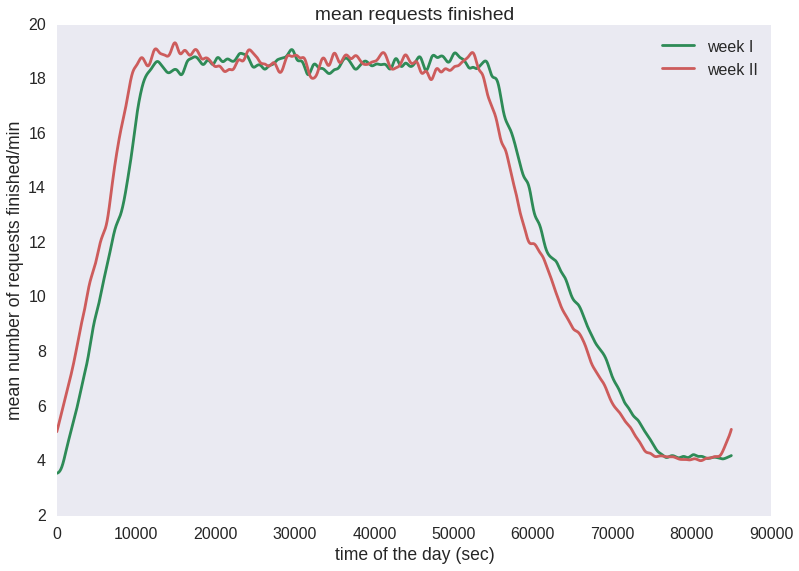

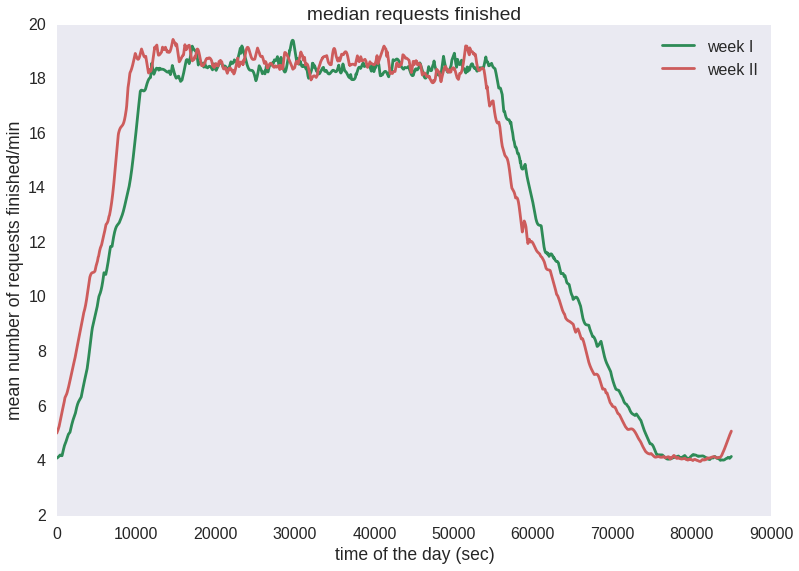

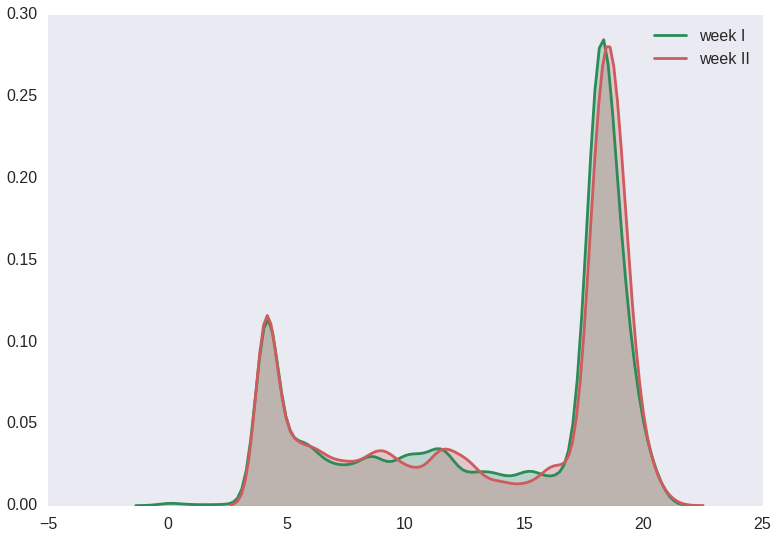

In [21]:
plt.plot(np.nanmean(split_days(df.num_reqs_filtered)[:7], axis=0), color='seagreen', label='week I')
plt.plot(np.nanmean(split_days(df.num_reqs_filtered)[7:], axis=0), color='indianred', label='week II')
plt.legend(loc='best')
plt.title('mean requests finished')
plt.xlabel('time of the day (sec)')
plt.ylabel('mean number of requests finished/min')

plt.figure()
plt.plot(np.nanmedian(split_days(df.rolling_reqs)[:7], axis=0), color='seagreen', label='week I')
plt.plot(np.nanmedian(split_days(df.rolling_reqs)[7:], axis=0), color='indianred', label='week II')
plt.legend(loc='best')
plt.title('median requests finished')
plt.xlabel('time of the day (sec)')
plt.ylabel('mean number of requests finished/min')

plt.figure()

sns.kdeplot(df.iloc[:85000*6].num_reqs_filtered, label='week I', color='seagreen', shade=True)
sns.kdeplot(df.iloc[85000*6:].num_reqs_filtered, label='week II', color='indianred', shade=True)

### The number of completed requests per minute is comparable, although it's lower for the last part of the day for week II.

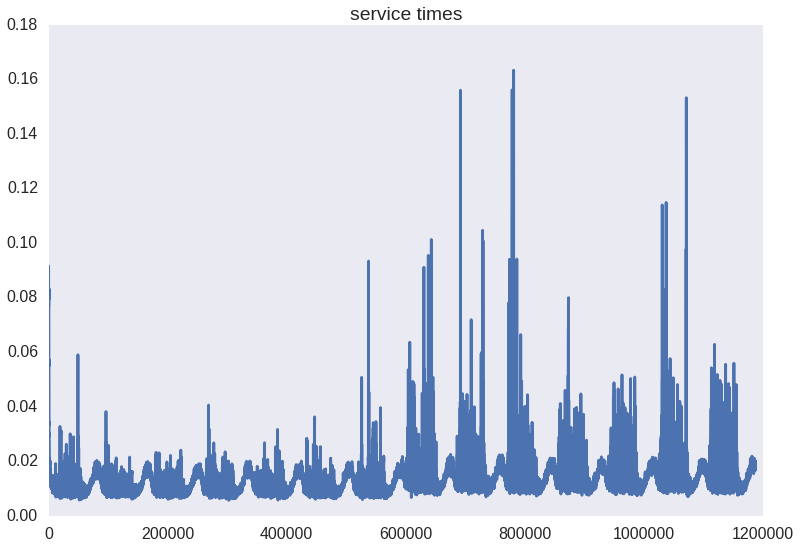

In [22]:
df['serv_times'] = df.rolling_resp_time_mean / (1 + df.rolling_reqs)
plt.plot(df.serv_times) 
plt.title('service times')

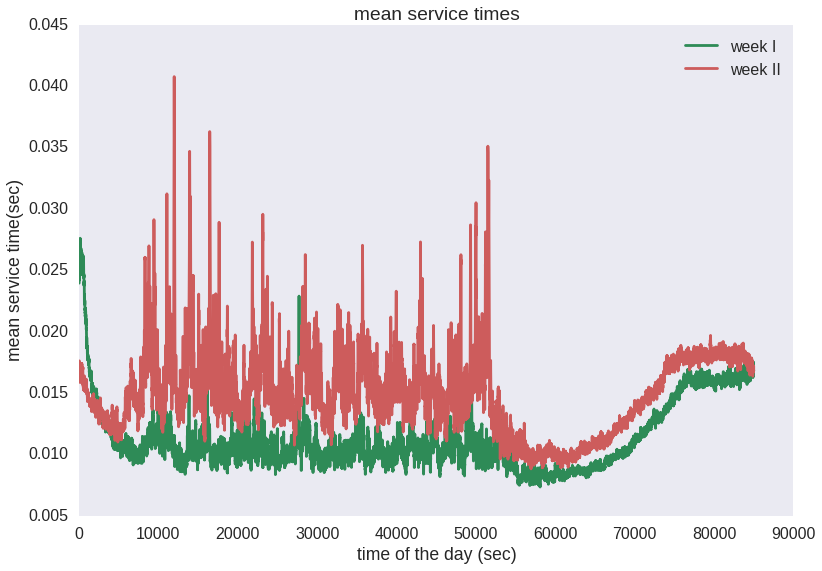

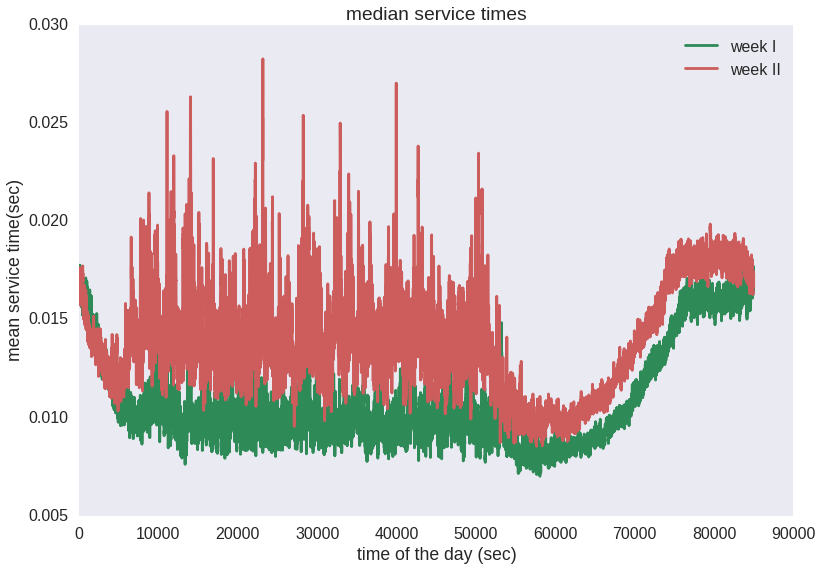

In [23]:
plt.plot(np.nanmean(split_days(df.serv_times)[:7], axis=0), color='seagreen', label='week I')
plt.plot(np.nanmean(split_days(df.serv_times)[7:], axis=0), color='indianred', label='week II')
plt.legend(loc='best')
plt.title('mean service times')
plt.xlabel('time of the day (sec)')
plt.ylabel('mean service time(sec)')

plt.figure()
plt.plot(np.nanmedian(split_days(df.serv_times)[:7], axis=0), color='seagreen', label='week I')
plt.plot(np.nanmedian(split_days(df.serv_times)[7:], axis=0), color='indianred', label='week II')
plt.legend(loc='best')
plt.title('median service times')
plt.xlabel('time of the day (sec)')
plt.ylabel('mean service time(sec)')

### Unlike in Scenario II, we see service times increase in the middle of cycle and at the end, on average. This difference is not due to the outliers.

(0, 0.05)

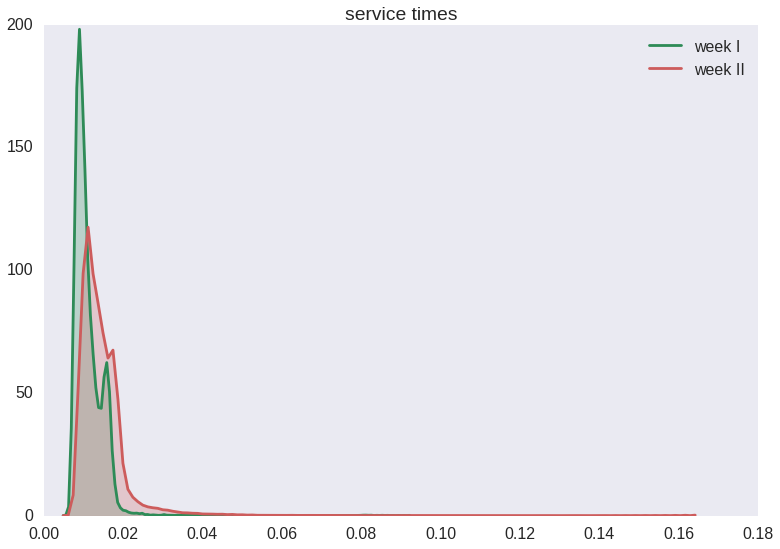

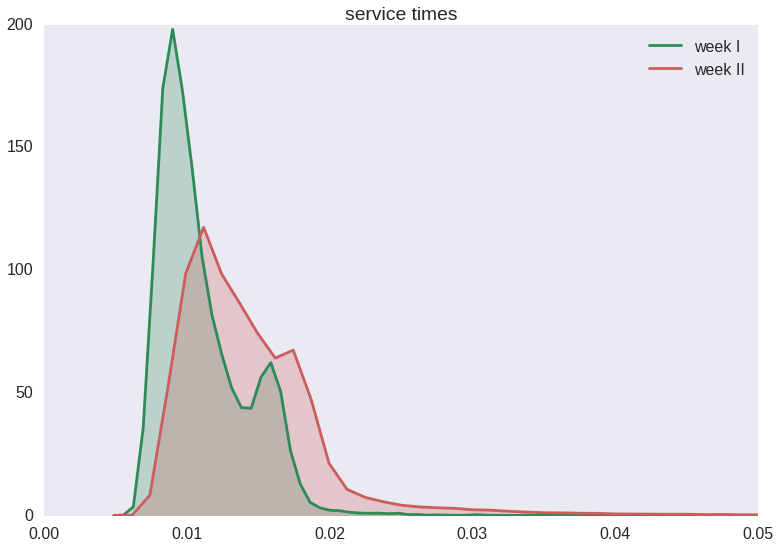

In [24]:
sns.kdeplot(df.iloc[:85000*6].serv_times, label='week I', color='seagreen', shade=True)
sns.kdeplot(df.iloc[85000*6:].serv_times, label='week II', color='indianred', shade=True)
plt.title('service times')

plt.figure()

sns.kdeplot(df.iloc[:85000*6].serv_times, label='week I', color='seagreen', shade=True)
sns.kdeplot(df.iloc[85000*6:].serv_times, label='week II', color='indianred', shade=True)
plt.title('service times')
plt.xlim(0, 0.05)

###My conclusion is that during Week II, the server was hit with requests that demanded on average more service time each, thus resulting in the increase in response times. The difference was consistent and not due to numerous outliers.